In [1]:
# Importo pandas, numpy y plt matplot para la gráfica
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
# Importo  las librerías necesarias
from sklearn import linear_model
from sklearn import model_selection

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
# Importamos la librería de métricas de sklearn
from sklearn.metrics import make_scorer, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
# Curva ROC
from sklearn.metrics import roc_curve, auc

## Métodos de clasificación
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

## Balanceado
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
#Estandarización
from sklearn.preprocessing import StandardScaler

# Importamos las librerias que vamos a necesitar
import obtenerDatos as oD
import conexionSGBD as cS
import util as ut
import modelos as mod
#import os
from datetime import datetime, timedelta
#os.chdir('D:\\Plagas')
#%matplotlib inline

A partir de un dataframe con los datos y el algoritmo deseado, que se le pasan como parámetros, hace:
- Para cada año coge el año en cuestión como datos de validación.
- El resto de años para datos de entrenamiento, se hace así porque cada año es prácticamente independiente del siguiente.
Me junta todos los resultados en un dataframe de forma que se pueda evaluar el rendimiento del algoritmo para todos los datos disponibles. 

In [2]:
## Función que me hace un k-folds con todos mis datos de entrenamiento por año.
def analizar(algoritmo, mdf):
    resultados=[]
    df_pred=pd.DataFrame()
    for anyo in range(2005,2025):
        # El año 2020 no lo evalua pues no hay datos
        if anyo != 2020:
            #Datos de entrenamiento: Todos menos el año actual
            # Datos de validación: El año actual
            df_train=mdf[((mdf['fecha'].dt.year != anyo))]
            df_val = mdf[(mdf['fecha'].dt.year == anyo)]
            df_validation=df_val
            X_train = np.array(df_train[atributos])
            Y_train = np.array(df_train['incidencia'])
            X_validation = np.array(df_validation[atributos])
            Y_validation = np.array(df_validation['incidencia'])
            model= algoritmo
            # Escalamos los datos con el escalador estándar pues hay desbalanceo de clases.
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_validation =  scaler.transform(X_validation) 
            # Hacemos un pipeline para sobremuestrear la clase minoritaria a un 0.6 de la mayoritaria.
            # Y submuestreamos la mayoritaria
            pipeline = Pipeline([
                ('oversample', SMOTE(sampling_strategy=0.6)),
                ('undersample', RandomUnderSampler(sampling_strategy=0.8))
            ])
            X_resampled, y_resampled = pipeline.fit_resample(X_train, Y_train)     
            model.fit(X_resampled,y_resampled) 
            ## Predicciones
            probabilidad = model.predict_proba(X_validation)[:, 1] 
            prediction=model.predict(X_validation) 
            ac=accuracy_score(Y_validation, prediction)
            resultados.append({'Año': anyo, 'Accuracy': ac,'Total':len(Y_validation) })
            #print(anyo)
            #print(confusion_matrix(Y_validation, prediction))
            #print(classification_report(Y_validation, prediction))
            df_val['prediccion']=prediction
            df_val['probabilidad']=probabilidad
            df_val['anyo']= pd.to_numeric(df_val['anyo'], errors='coerce').astype(int)
            # Concatenamos los valores de  este año con el resto
            df_pred=pd.concat([df_pred, df_val[['idMunicipio','fecha','anyo','semana','generacion','incidencia','prediccion','probabilidad','dias_grado_ac','num_vuelos_n']]], ignore_index=True)
    return df_pred

La siguiente función nos dibuja la curvaROC del dataframe que se le pasa después del procedimiento de validación.

In [3]:
def curvaROC(df_dibujar):
# Calcular la probabilidad de la clase 0 para RF
    df_dibujar['probabilidad_0'] = 1 - df_dibujar['probabilidad']
    
    # Extraer valores
    y_true = df_dibujar['incidencia'].values  # Clases reales
    y_score_1 = df_dibujar['probabilidad'].values  # Probabilidad de la clase 1
    y_score_0 = df_dibujar['probabilidad_0'].values  # Probabilidad de la clase 0
    
    # Calcular la curva ROC para la clase 1
    fpr_1, tpr_1, _ = roc_curve(y_true, y_score_1)
    roc_auc_1 = auc(fpr_1, tpr_1)
    
    # Calcular la curva ROC para la clase 0 (invirtiendo las etiquetas)
    fpr_0, tpr_0, _ = roc_curve(1 - y_true, y_score_0)
    roc_auc_0 = auc(fpr_0, tpr_0)
    
    # Graficar ambas curvas ROC
    plt.figure(figsize=(8, 6))
    
    plt.plot(fpr_1, tpr_1, color='blue', lw=2, label=f'ROC Clase 1 (AUC = {roc_auc_1:.2f})')
    plt.plot(fpr_0, tpr_0, color='red', lw=2, label=f'ROC Clase 0 (AUC = {roc_auc_0:.2f})')
    
    # Graficar la línea de azar (y = x)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    
    #  Configuración de la gráfica
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title('Curva ROC para incidencia de plaga')
    plt.legend(loc="lower right")
    plt.show()

Para no tener que calcular cada vez que probamos un algoritmo hemos guardado el modelo de datos en base de datos. Lo recuperamos y definimos los atributos que vamos a escalar

In [ ]:
#df=cS.getTodoModelo()
df=mod.calcularModeloSimple()
df['generacionC']=df['generacion']
df['anyoC']=df['anyo']
df['idMunicipioC']=df['idMunicipio']
df['dias_grado_ac_c']=df['dias_grado_ac']
atributos = [ 'altitud','generacionC', 'anyoC', 'dias_grado_ac_c', \
             'semana','dia_g', \
             't_min','t_max','t_med','hr_med','vv_med', \
             't_min_p','t_max_p','t_med_p','hr_med_p','vv_med_p', \
                         'dias_grado_ac_7', 'rg_md_7', 'hr_md_7', 't_med_7', \
                         'dias_grado_ac_28','t_med_28','rg_md_28','hr_md_28', \
                         'num_vuelos_1','num_vuelos_2','num_vuelos_3','num_vuelos_4','num_vuelos_5','num_vuelos_6']

En esta celda cogemos tres años al azar y dividimos los datos en validación, para estos tres, y entrenamiento el resto.
Aplicamos todo el proceso para obtener los hiperparámetros más adecuados a nuestro algoritmo que nos dé una mejor valoración para recall.

In [ ]:
df_train = df[~df['anyo'].isin([2006, 2010, 2021])]
df_val = df[df['anyo'].isin([2006, 2010, 2021])]
df_validation=df_val
X_train = np.array(df_train[atributos])
y_train = np.array(df_train['incidencia'])
X_test = np.array(df_validation[atributos])
y_test = np.array(df_validation['incidencia'])
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) 
pipeline = Pipeline([
    ('oversample', SMOTE(sampling_strategy=0.6)),
    ('undersample', RandomUnderSampler(sampling_strategy=0.8))
])

X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)  

rf = RandomForestClassifier()

# Definir el grid de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],  # Número de árboles
    'max_depth': [10, 20, None],  # Profundidad máx
    'max_features': ['sqrt', 'log2'],  # Número de características por split
    'min_samples_split': [2, 5, 10],  # Mínimas muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],  # Mínimas muestras en cada hoja
    'bootstrap': [True, False]  # Con o sin reemplazo
}

# Configurar GridSearchCV
scorer = make_scorer(recall_score, pos_label=1)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring=scorer, n_jobs=-1, verbose=2)

# Ejecutar la búsqueda
grid_search.fit(X_resampled, y_resampled)

# Mostrar los mejores hiperparámetros
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor puntuación:", grid_search.best_score_)

# Evaluar en el conjunto de prueba
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Accuracy en test:", accuracy_score(y_test, y_pred))

Copiamos el dataframe para no tener que recuperarlo cada vez que lanzamos la siguiente celda.

In [5]:
dfb=df.copy()
dfb=dfb[[ 'generacionC', 'anyoC', 'dias_grado_ac_c', 'fecha', 'incidencia','idMunicipio', 'anyo','generacion','num_vuelos_n',\
             'altitud','semana','dia_g', 'dias_grado_ac', \
             't_min','t_max','t_med','hr_med','vv_med', \
             't_min_p','t_max_p','t_med_p','hr_med_p','vv_med_p', \
                         'dias_grado_ac_7', 'rg_md_7', 'hr_md_7', 't_med_7', \
                         'dias_grado_ac_28','t_med_28','rg_md_28','hr_md_28', \
         'num_vuelos_1','num_vuelos_2','num_vuelos_3','num_vuelos_4','num_vuelos_5','num_vuelos_6']] 
atributos = ['generacionC', 'anyoC', 'dias_grado_ac_c', \
             'semana','dia_g', \
             't_min','t_max','t_med','hr_med','vv_med', \
             't_min_p','t_max_p','t_med_p','hr_med_p','vv_med_p', \
                         'dias_grado_ac_7', 'rg_md_7', 'hr_md_7', 't_med_7', \
                         'dias_grado_ac_28','t_med_28','rg_md_28','hr_md_28', \
                         'num_vuelos_1','num_vuelos_2','num_vuelos_3','num_vuelos_4','num_vuelos_5','num_vuelos_6']

Con la siguiente celda se analizan los algoritmos deseados, llamando a la función analizar (que nos hace un kfold) y obtenemos la matriz de confusión 
para todos los valores y la primera generación, que es la que nos va a marcar el camino.
Si queremos analizar un algoritmo en concreto, basta con descomentarlo.

¡¡OJO!! SVC y XGBoost no tienen la función probabilidad, por lo que habría que comentarlo en analizar y la curva ROC

RF
0.8849869651893881
[[8731  737]
 [ 763 2811]]
              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92      9468
         1.0       0.79      0.79      0.79      3574

    accuracy                           0.88     13042
   macro avg       0.86      0.85      0.86     13042
weighted avg       0.88      0.88      0.88     13042

0.8617610287551348
[[3039  460]
 [ 314 1786]]
              precision    recall  f1-score   support

         0.0       0.91      0.87      0.89      3499
         1.0       0.80      0.85      0.82      2100

    accuracy                           0.86      5599
   macro avg       0.85      0.86      0.85      5599
weighted avg       0.86      0.86      0.86      5599



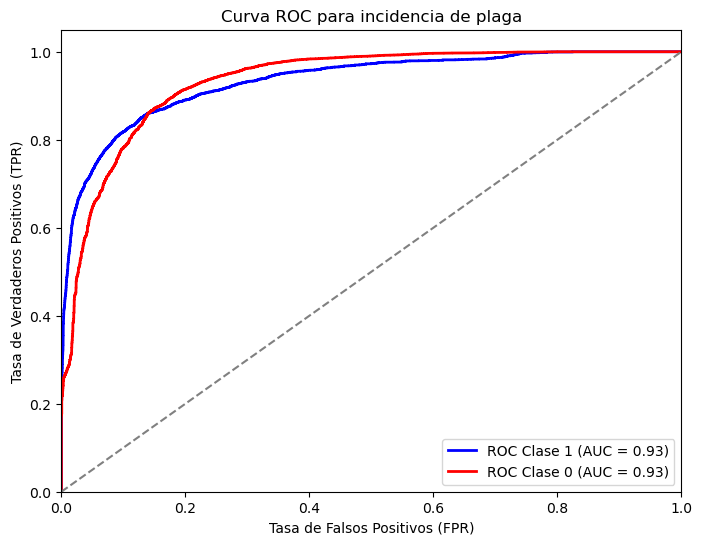

In [ ]:
#Incluimos los modelos a evaluar en nuestro KFolds particular
models=[]
# Random Forest optimizado para mejorar recall.
#models.append(("RF",RandomForestClassifier(bootstrap= False, max_depth=20,  max_features='log2', min_samples_leaf=1, min_samples_split= 2, n_estimators= 100)))
# Random Forest para mejor accuracy
#models.append(("RF",RandomForestClassifier(bootstrap= False, max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split= 2, n_estimators= 200)))
#Ramom Forest para mejor compromiso
models.append(("Bag",BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, n_jobs=-1, random_state=42)))
models.append(("KNN",KNeighborsClassifier()))
models.append(("NB",GaussianNB()))
models.append(("SVM", SVC(gamma='auto', kernel="linear", probability=True)))
models.append(("XGB",XGBClassifier(n_estimators=132, max_depth=15,  objective='binary:logistic', max_delta_step=1,random_state=42)))
models.append(("RF",RandomForestClassifier(class_weight= None, max_depth=7, min_samples_leaf=4, min_samples_split=2, n_estimators=132)))
for name, model in models:
    #model.fit(X_train,Y_train)
    df_analizado=analizar(model,dfb)
    df_analizado['algoritmo']=name
    print(name)
    print(accuracy_score(df_analizado['incidencia'], df_analizado['prediccion']))
    print(confusion_matrix(df_analizado['incidencia'], df_analizado['prediccion']))
    print(classification_report(df_analizado['incidencia'], df_analizado['prediccion']))
    print(accuracy_score(df_analizado[df_analizado['generacion']==1]['incidencia'], df_analizado[df_analizado['generacion']==1]['prediccion']))
    print(confusion_matrix(df_analizado[df_analizado['generacion']==1]['incidencia'], df_analizado[df_analizado['generacion']==1]['prediccion']))
    print(classification_report(df_analizado[df_analizado['generacion']==1]['incidencia'], df_analizado[df_analizado['generacion']==1]['prediccion']))
    curvaROC(df_analizado)
    df_analizado['algoritmo']=name
    #cS.insertaTabla('AP',df_analizado[['algoritmo','idMunicipio','fecha','anyo','generacion','incidencia','prediccion','num_vuelos_n','dias_grado_ac','probabilidad']])

Con el df_analizado que nos quedemos, en este caso Random Forest, de la celda superior, desglosamos valores por municipio.

In [16]:
municipios=[11,36,59,75,84,102,125]
for muni in municipios:
    print(muni)
    #print(accuracy_score(df_analizado['incidencia'][df_analizado['idMunicipio']==muni], df_analizado['prediccion'][df_analizado['idMunicipio']==muni]))
    print(confusion_matrix(df_analizado['incidencia'][df_analizado['idMunicipio']==muni], df_analizado['prediccion'][df_analizado['idMunicipio']==muni]))
    print(classification_report(df_analizado['incidencia'][df_analizado['idMunicipio']==muni], df_analizado['prediccion'][df_analizado['idMunicipio']==muni]))
    #print(accuracy_score(
     #   df_analizado[(df_analizado['generacion'] == 1) & (df_analizado['idMunicipio'] == muni)]['incidencia'], 
     #   df_analizado[(df_analizado['generacion'] == 1) & (df_analizado['idMunicipio'] == muni)]['prediccion']
    #))
    print("Primera generación")
    print(confusion_matrix(
        df_analizado[(df_analizado['generacion'] == 1) & (df_analizado['idMunicipio'] == muni)]['incidencia'], 
        df_analizado[(df_analizado['generacion'] == 1) & (df_analizado['idMunicipio'] == muni)]['prediccion']
    ))
    print(classification_report(
        df_analizado[(df_analizado['generacion'] == 1) & (df_analizado['idMunicipio'] == muni)]['incidencia'], 
        df_analizado[(df_analizado['generacion'] == 1) & (df_analizado['idMunicipio'] == muni)]['prediccion']
    ))

11
[[1933  278]
 [ 124  832]]
              precision    recall  f1-score   support

         0.0       0.94      0.87      0.91      2211
         1.0       0.75      0.87      0.81       956

    accuracy                           0.87      3167
   macro avg       0.84      0.87      0.86      3167
weighted avg       0.88      0.87      0.88      3167

Primera generación
[[566 186]
 [ 47 512]]
              precision    recall  f1-score   support

         0.0       0.92      0.75      0.83       752
         1.0       0.73      0.92      0.81       559

    accuracy                           0.82      1311
   macro avg       0.83      0.83      0.82      1311
weighted avg       0.84      0.82      0.82      1311

36
[[1604   16]
 [  39   80]]
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      1620
         1.0       0.83      0.67      0.74       119

    accuracy                           0.97      1739
   macro avg       0.90   